# News Recommendation System


The News Article Recommendation System is designed to deliver personalized article suggestions by analyzing the content of news headlines. It leverages natural language processing (NLP) techniques and machine learning algorithms to understand and compare the semantic similarities between different news articles. This allows the system to recommend relevant content that aligns with each user's interests and reading patterns. The primary objective is to enhance the user experience by offering curated recommendations that reflect individual preferences. By capturing the underlying meaning of headlines, the system effectively connects related articles and presents users with a customized selection of content tailored to their interests.

## Importing Necessary Libraries


In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
import os
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import pairwise_distances

## Loading Data

In [2]:
raw_df = pd.read_json("News_Category_Dataset_v2.json")

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category           132 non-null    object        
 1   headline           132 non-null    object        
 2   authors            132 non-null    object        
 3   link               132 non-null    object        
 4   short_description  132 non-null    object        
 5   date               132 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 6.3+ KB


In [4]:
raw_df.describe()

C:\Users\shiva\AppData\Local\Temp\ipykernel_18324\2990293585.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  raw_df.describe()


,category,headline,authors,link,short_description,date
count,132,132,132,132,132,132
unique,16,132,97,105,132,10
top,CRICKET,Trump Names Billionaire Private Astronaut Jare...,Hindustan Times,https://www.hindustantimes.com/entertainment,"Jared Isaacman, known for his ties to Elon Mus...",2024-12-12 00:00:00
freq,18,1,13,8,1,41
first,NaN,NaN,NaN,NaN,NaN,2024-12-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2024-12-12 00:00:00


In [5]:
raw_df.columns.unique()

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [6]:
raw_df.head()

,category,headline,authors,link,short_description,date
0,WORLD NEWS,Trump Names Billionaire Private Astronaut Jare...,Livemint Staff,https://www.livemint.com,"Jared Isaacman, known for his ties to Elon Mus...",2024-12-04
1,US NEWS,South Korean President Faces Impeachment Amid ...,Livemint Staff,https://www.livemint.com,President Yoon Suk Yeol declared martial law f...,2024-12-04
2,POLITICS,Donald Trump Challenges 34 Felony Counts in Ne...,Hindustan Times Staff,https://www.hindustantimes.com,Trump requested the dismissal of charges linke...,2024-12-04
3,WORLD NEWS,India Votes for UN Resolution Urging Israel to...,Livemint Staff,https://www.livemint.com,India reaffirmed its support for a two-state s...,2024-12-04
4,US NEWS,Elon Musk and Vivek Ramaswamy Push to Abolish ...,Hindustan Times Staff,https://www.hindustantimes.com,A public initiative led by Musk and Ramaswamy ...,2024-12-04


In [7]:
raw_df.tail()

,category,headline,authors,link,short_description,date
127,EDUCATION,CBSE Declares 2024 Exam Results Earlier Than E...,"NDTV, Times of India",https://www.ndtv.com/cbse-2024-results-earlier...,CBSE announces early 2024 exam results with im...,2024-12-12
128,EDUCATION,CBSE Introduces New Curriculum Changes Focused...,"Hindustan Times, The Hindu",https://www.hindustantimes.com/cbse-curriculum...,CBSE updates its curriculum to emphasize skill...,2024-12-11
129,EDUCATION,CBSE Board Exams 2024: Strict Security Measure...,"The Indian Express, Times Now",https://www.indianexpress.com/cbse-exam-securi...,CBSE enhances exam security to prevent cheatin...,2024-12-10
130,EDUCATION,CBSE Releases New Exam Guidelines for Digital ...,"Economic Times, Education Times",https://www.economictimes.com/cbse-digital-eva...,CBSE implements digital evaluation systems for...,2024-12-10
131,EDUCATION,CBSE Launches Online Learning Portal for Reduc...,"PTI, The Tribune",https://www.tribuneindia.com/cbse-online-porta...,CBSE introduces an online portal to facilitate...,2024-12-11


## Data Preprocessing

#### Fetching only the articles from 2024

If the dataset size become quite large so processing through entire dataset may consume too much time.

In [8]:
start_date = pd.Timestamp(2024, 1, 1)
raw_df = raw_df[raw_df['date'] >= start_date]

In [9]:
raw_df.shape

(132, 6)

In [10]:
# Sort the DataFrame by headline in descending order
raw_df.sort_values('headline', inplace=True, ascending=False)

# Find duplicate articles based on the 'headline' column
duplicate_raw_df = raw_df.duplicated('headline', keep=False)

# Remove duplicate articles from the DataFrame
raw_df = raw_df[~duplicate_raw_df]

# Print the total number of articles after removing duplicates
print(raw_df.shape)

(132, 6)


#### Checking for null values

In [11]:
raw_df.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [12]:
raw_df.reset_index(inplace = True)
raw_df

,index,category,headline,authors,link,short_description,date
0,51,SPORTS,Yashasvi Jaiswal's Sledge Leaves Nathan Lyon S...,Hindustan Times,https://www.hindustantimes.com/cricket/yashasv...,The young Indian batter made a playful remark ...,2024-12-05
1,41,CRICKET,Yashasvi Jaiswal's Comment 'Too Slow' May Have...,Ricky Ponting Commentary,https://www.indiatoday.in/sports/cricket/story...,Former captain Ricky Ponting suggested Jaiswal...,2024-12-11
2,61,EDUCATION,XAT 2025 Exam Records High Registrations,Careers360,https://news.careers360.com,"XAT 2025 scheduled for January 5, 2025, with a...",2024-12-12
3,98,HEALTH,World Health Organization Warns of Rising Case...,"WHO, Reuters Health",https://www.who.int/news/item/12-12-2024-obesi...,The WHO reports a global rise in obesity rates...,2024-12-12
4,105,COVID,WHO Recommends Updated COVID-19 Vaccines Targe...,"WHO, Bloomberg",https://www.bloomberg.com/news/articles/12-10-...,The WHO advises the use of updated COVID-19 va...,2024-12-10
...,...,...,...,...,...,...,...
127,123,EDUCATION,Aktu Admissions 2024: Increased Applications i...,"The Hindu, Aktu Admissions Office",https://www.thehindu.com/aktu-admissions-2024-...,Aktu sees a surge in applications for engineer...,2024-12-11
128,8,TECHNOLOGY,Affordable Rivals Challenge Apple's Vision Pro...,TechRadar Staff,https://www.techradar.com,Xreal and Asus launch cost-effective AR/VR dev...,2024-12-06
129,13,ENTERTAINMENT,AI-Generated Movie Trailer Wins Prestigious Fi...,Hollywood Insider,https://www.hollywoodinsider.com,The use of AI in entertainment reaches new hei...,2024-12-06
130,19,TECHNOLOGY,AI Breakthrough in Creative Problem-Solving,Tech Innovators,https://www.technologyreview.com,An AI system achieves top 1% performance in cr...,2024-12-11


#### Removing all the short headline articles

In [13]:
counts = raw_df.category.value_counts()
counts

CRICKET          18
EDUCATION        17
SPORTS           15
POLITICS         15
ENTERTAINMENT    14
TECHNOLOGY        9
ENVIRONMENT       8
CRIME             8
HEALTH            6
SCIENCE           6
COVID             5
ELECTION          5
WORLD NEWS        2
US NEWS           2
FOOTBALL          1
BASKETBALL        1
Name: category, dtype: int64

In [14]:
raw_df = raw_df[raw_df['headline'].str.split().apply(len) > 5]
total_articles = len(raw_df)
print("Total number of articles after removing headlines with fewer than 5 words:", total_articles)

Total number of articles after removing headlines with fewer than 5 words: 130


In [15]:
raw_df['category']

0             SPORTS
1            CRICKET
2          EDUCATION
3             HEALTH
4              COVID
           ...      
126        EDUCATION
127        EDUCATION
128       TECHNOLOGY
129    ENTERTAINMENT
131    ENTERTAINMENT
Name: category, Length: 130, dtype: object

## Data Visualization

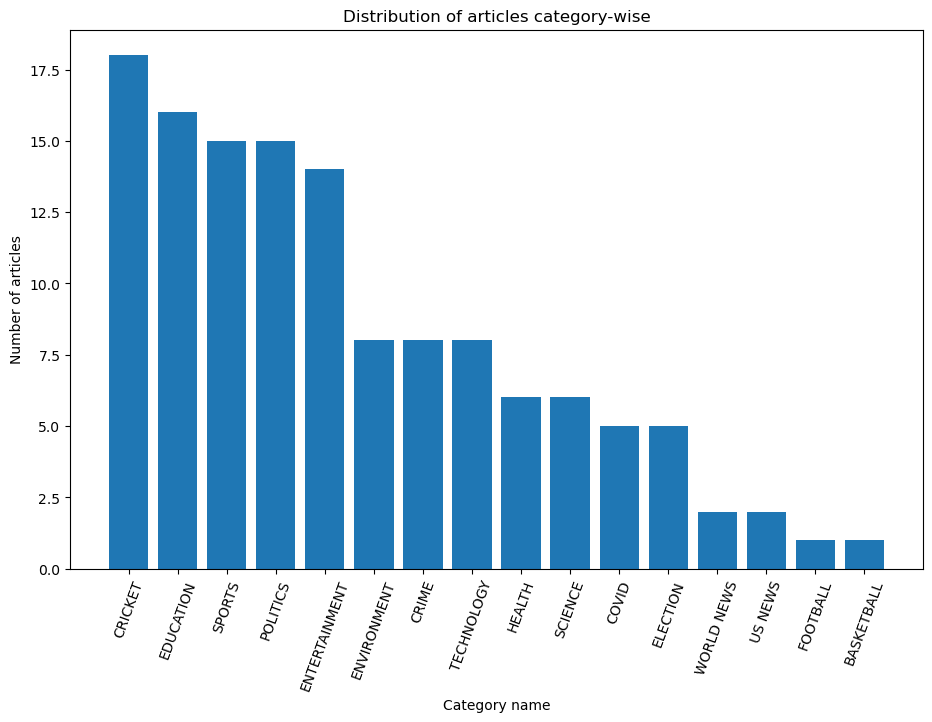

In [16]:
category_counts = raw_df["category"].value_counts()

plt.figure(figsize=(11, 7))
plt.bar(category_counts.index, category_counts.values)
plt.title("Distribution of articles category-wise")
plt.xlabel("Category name")
plt.ylabel("Number of articles")
plt.xticks(rotation=70)
plt.show()

In [17]:
news_articles_per_month = raw_df['date'].dt.month.value_counts().sort_index()
news_articles_per_month


12    130
Name: date, dtype: int64

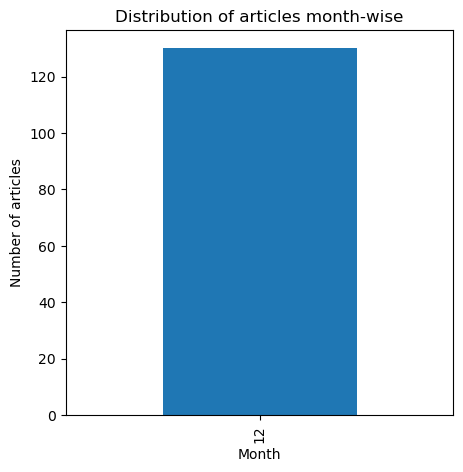

In [18]:
news_articles_per_month.plot(kind='bar', figsize=(5, 5))
plt.title("Distribution of articles month-wise")
plt.xlabel("Month")
plt.ylabel("Number of articles")
plt.show()

C:\Users\shiva\AppData\Local\Temp\ipykernel_18324\3671882502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['date'] = pd.to_datetime(raw_df['date'])


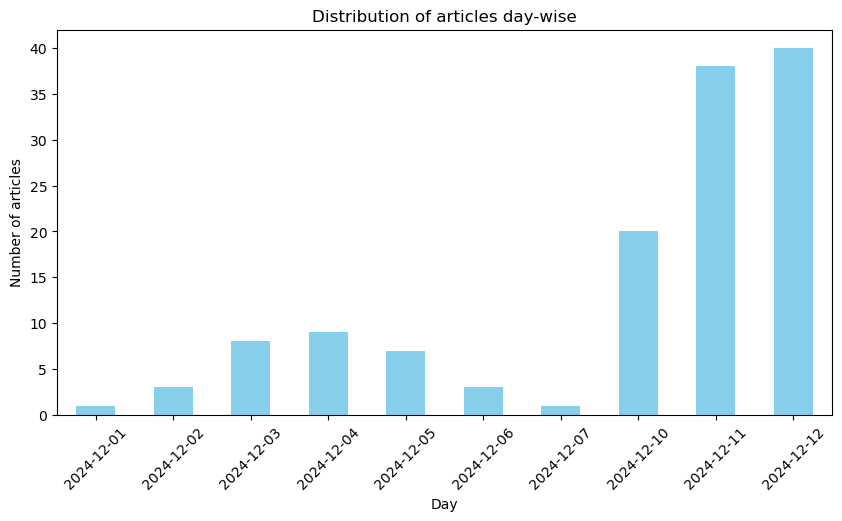

In [19]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

# Group by day and count the number of articles
articles_per_day = raw_df.groupby(raw_df['date'].dt.date).size()

# Plot the distribution day-wise
plt.figure(figsize=(10, 5))
articles_per_day.plot(kind='bar', color='skyblue')
plt.title("Distribution of articles day-wise")
plt.xlabel("Day")
plt.ylabel("Number of articles")
plt.xticks(rotation=45)
plt.show()

In [20]:
raw_df_temp = raw_df.copy()

In [21]:
# Set of stopwords in English
stop_words = set(stopwords.words('english'))

# Loop through each headline in the DataFrame
for i, headline in enumerate(raw_df_temp["headline"]):
    processed_words = []
    
    # Split the headline into individual words
    for word in headline.split():
        # Remove punctuation and convert to lowercase
        word = ''.join(e for e in word if e.isalnum())
        word = word.lower()
        
        # Check if word is not a stopword
        if word not in stop_words:
            processed_words.append(word)
    
    # Join the processed words and assign back to the DataFrame
    raw_df_temp.at[i, "headline"] = ' '.join(processed_words)
    
    # Print progress every 1000 iterations
    if i % 1000 == 0:
        print(i)


0


#### Lemmatization

In [22]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

for i in range(len(raw_df_temp["headline"])):
    if i in raw_df_temp.index:
        string = ""
        for w in word_tokenize(raw_df_temp["headline"][i]):
            string += lemmatizer.lemmatize(w, pos="v") + " "
        raw_df_temp.at[i, "headline"] = string.strip()
    if i % 1000 == 0:
        print(i)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0


## TF-IDF method

In [23]:
!pip install scikit-learn

tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(raw_df_temp['headline'])


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features, tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[1:num_similar_items+1]
    
    recommended_articles = raw_df.iloc[indices][["date", "headline"]]
    queried_article_headline = raw_df["headline"].iloc[indices[0]]
    
    print("="*30, "Queried article details", "="*30)
    print('headline:', queried_article_headline)
    print("\n", "="*25, "Recommended articles", "="*23)
    
    return recommended_articles

tfidf_based_model(1, 11)

============================== Queried article details ==============================
headline: Yashasvi Jaiswal's Sledge Leaves Nathan Lyon Surprised

 ========================= Recommended articles =======================


,date,headline
0,2024-12-05,Yashasvi Jaiswal's Sledge Leaves Nathan Lyon S...
98,2024-12-11,Cancer Survivors Experience Long-Term Mental H...
62,2024-12-03,Mithali Raj Reflects on Pressure to Quit Crick...
118,2024-12-04,Ariana Grande Gets Emotional Over Glinda’s Wan...
6,2024-12-10,Voter Turnout Breaks Records in Midterm Electi...
86,2024-12-11,Google Pixel 8 Pro Officially Unveiled with Ad...
88,2024-12-12,Global Leaders Push for Tax Reforms to Close W...
89,2024-12-11,Global COVID-19 Vaccine Booster Campaign Faces...
53,2024-12-12,New Study Finds Link Between Poor Sleep and In...
51,2024-12-12,New Study Reveals Quantum Computing Breakthrou...


In [25]:
# Ensure the dataset has the necessary columns
if 'headline' not in raw_df.columns or 'link' not in raw_df.columns:
    raise ValueError("Dataset must include 'headline' and 'link' columns.")

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(raw_df['headline'])

def recommend_articles(user_input, num_similar_items=5):
    # Transform the user input to match the TF-IDF matrix space
    user_input_tfidf = vectorizer.transform([user_input])
    
    # Compute similarity with all headlines in the dataset
    similarities = cosine_similarity(user_input_tfidf, tfidf_matrix).flatten()
    
    # Get indices of the most similar articles
    similar_indices = similarities.argsort()[-(num_similar_items+1):][::-1]  # Top N + 1 (including the input article)
    
    # Fetch similar articles
    recommended_articles = raw_df.iloc[similar_indices[1:num_similar_items+1]][["headline", "link"]]
    queried_article = raw_df.iloc[similar_indices[0]]  # Most similar article (user's input match)

    print("=" * 30, "Queried Article", "=" * 30)
    print("Headline:", queried_article['headline'])
    print("Link:", queried_article['link'])
    print("\n", "=" * 25, "Recommended Articles", "=" * 23)
    print(recommended_articles.to_string(index=False))

    return recommended_articles

# Take user input and call the recommendation function
user_input = input("Enter a headline or keywords to search for similar articles: ")
recommend_articles(user_input, num_similar_items=5)


Enter a headline or keywords to search for similar articles: ipl
============================== Queried Article ==============================
Headline: Rohit Sharma Leads Mumbai Indians to IPL 2024 Victory
Link: https://www.cricbuzz.com/rohit-sharma-mumbai-indians-ipl-victory-2024

 ========================= Recommended Articles =======================
                                                                headline                                                                  link
    Mumbai Indians Acquire Nuwan Thushara for ₹4.8 Crores in IPL Auction                                                https://www.wisden.com
IPL 2024: Chennai Super Kings Clinch Championship with Last-Over Victory        https://www.sportstar.com/ipl-2024-chennai-super-kings-victory
             IPL 2024 Auction Sees Record-Breaking Bids for Young Talent https://www.sportskeeda.com/ipl/2024-auction-record-bids-young-talent
                                       Moana 2 Breaks Box Office Records

,headline,link
60,Mumbai Indians Acquire Nuwan Thushara for ₹4.8...,https://www.wisden.com
79,IPL 2024: Chennai Super Kings Clinch Champions...,https://www.sportstar.com/ipl-2024-chennai-sup...
80,IPL 2024 Auction Sees Record-Breaking Bids for...,https://www.sportskeeda.com/ipl/2024-auction-r...
61,Moana 2 Breaks Box Office Records,https://www.showtimes.com/news/2024-december/
47,Phishing Scams Surge During Holiday Season,https://www.techradar.com


In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# Load the JSON dataset
raw_df = pd.read_json("News_Category_Dataset_v2.json")

# Ensure necessary columns
required_columns = ['category', 'headline', 'link']
for col in required_columns:
    if col not in raw_df.columns:
        raise ValueError(f"Dataset must include the following columns: {', '.join(required_columns)}")

# Function to recommend articles based on user-selected categories
def recommend_articles_by_categories(user_categories, num_similar_items=5):
    user_categories = [category.strip() for category in user_categories.split(',')]
    filtered_articles = pd.DataFrame()
    
    for category in user_categories:
        filtered_df = raw_df[raw_df['category'].str.contains(category, case=False, na=False)]
        filtered_articles = pd.concat([filtered_articles, filtered_df])
    
    if filtered_articles.empty:
        print(f"No articles found for the categories: {', '.join(user_categories)}. Please try different categories.")
        return
    
    # TF-IDF Vectorization for the combined dataset
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(filtered_articles['headline'])
    
    # Compute similarity with all headlines in the combined dataset
    similarities = cosine_similarity(tfidf_matrix, tfidf_matrix).mean(axis=1)
    
    # Get indices of the most similar articles
    similar_indices = similarities.argsort()[-num_similar_items:][::-1]
    
    # Fetch recommended articles
    recommended_articles = filtered_articles.iloc[similar_indices][["headline", "link"]]
    
    print("=" * 30, "Recommended Articles", "=" * 30)
    print(recommended_articles.to_string(index=False))
    return recommended_articles

# Display available categories to the user
print("Available categories:", raw_df['category'].unique())

# User selects multiple categories
user_input = input("Choose categories you're interested in (comma-separated, e.g., Sports, Technology, Health): ")

# Recommend articles based on the chosen categories
recommend_articles_by_categories(user_input)


Available categories: ['WORLD NEWS' 'US NEWS' 'POLITICS' 'ENTERTAINMENT' 'ENVIRONMENT' 'CRIME'
 'TECHNOLOGY' 'SCIENCE' 'HEALTH' 'CRICKET' 'FOOTBALL' 'BASKETBALL'
 'SPORTS' 'EDUCATION' 'COVID' 'ELECTION']
Choose categories you're interested in (comma-separated, e.g., Sports, Technology, Health): health
============================== Recommended Articles ==============================
                                                                   headline                                                                                         link
New Study Finds Link Between Poor Sleep and Increased Risk of Heart Disease         https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(24)XXXXXX-8/fulltext
   Scientists Identify Gene Linked to Increased Risk of Alzheimer’s Disease               https://www.nih.gov/news-events/news-releases/gene-linked-alzheimers-risk-2024
Cancer Survivors Experience Long-Term Mental Health Challenges, Study Finds                   https://www.j

,headline,link
97,New Study Finds Link Between Poor Sleep and In...,https://www.thelancet.com/journals/lancet/arti...
101,Scientists Identify Gene Linked to Increased R...,https://www.nih.gov/news-events/news-releases/...
100,Cancer Survivors Experience Long-Term Mental H...,https://www.jco.org/article/cancer-survivors-m...
98,World Health Organization Warns of Rising Case...,https://www.who.int/news/item/12-12-2024-obesi...
99,"FDA Approves New Drug for Severe Asthma, Provi...",https://www.fda.gov/news-events/press-announce...
